## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
# Import libraryu for load file pkl and txt
import pickle  
import json 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.layers import InputLayer, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns



## 2. Data Loading and Preparation

### 2.1 Data Loading

In [2]:
# load file from DatasetWithTagFinal to dataframe
df = pd.read_csv('../dataset/DatasetWithTagFinal.csv')

In [3]:
# Check 5 top data in df
df.head()

,sentence,kata,tag
0,Kalimat 1,forza,B-Game
1,Kalimat 1,horizon,E-Game
2,Kalimat 1,om,O
3,Kalimat 1,sekali,O
4,Kalimat 1,install,B-Request


### 2.2 Remove tag O

In [4]:
# delete df that contain tag 'O' , the reason is to prevent missleading accuracy with label inbalance 
df = df[df['tag'] != 'O']

### 2.3 Create list index data for every word and tag in df, and export it to file json

In [5]:
print("Unique words in corpus:", df['kata'].nunique())
print("Unique tags in corpus:", df['tag'].nunique())

# create list of unique words in column kata
words = list(set(df["kata"].values))
num_words = len(words)

# create list of unique in column tag
tags = list(set(df["tag"].values))
num_tags = len(tags)

Unique words in corpus: 353
Unique tags in corpus: 48


In [6]:
# Create dictionary with word as key and index as value
word2idx = {w: i + 1 for i, w in enumerate(words)}

# Create dictionary with tag as key and index as value
tag2idx = {t: i + 1 for i, t in enumerate(tags)}

In [7]:
# export word2idx and tag2idx to file json that will used for model inferential
with open('wordDict.json', 'w') as file1:
    json.dump(word2idx, file1)

with open('tagDict.json', 'w') as file2:
    json.dump(tag2idx, file2)

with open('./deployment_streamlit/wordDict.json', 'w') as file3:
    json.dump(word2idx, file3)

with open('./deployment_streamlit/tagDict.json', 'w') as file4:
    json.dump(tag2idx, file4)

### 2.4 Convert word and tag to index and make pad_sequence

In [8]:
# Class to get word and its tag for every sentence with format array tuple
class List_Format_NER(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s: [(w, t) for w, t in zip(s['kata'].values.tolist(),
                                                s['tag'].values.tolist())]
        self.grouped = self.df.groupby("sentence").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Kalimat: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s
        except KeyError:
            return None

# Displaying one full sentence
list_format_ner = List_Format_NER(df)

/var/folders/cr/8g19f6x13sn907v0ff4vkmm80000gn/T/ipykernel_22097/2418511087.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.df.groupby("sentence").apply(agg)


In [9]:
list_sentence = list_format_ner.sentences

max_len = 40

# convert every word to index and make pad_sequence to ease process model training
X = [[word2idx[w[0]] for w in s] for s in list_sentence]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post")

# convert every tag to index and make pad_sequence to ease process model training
y = [[tag2idx[w[1]] for w in s] for s in list_sentence]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post")

### 2.5 Split data for train and test

In [10]:
# Split data for model train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## 3. Model Training

In [11]:
# Define the embedding dimension
embedding_dim = 50  # This is an example value; choose based on your needs

model = keras.Sequential()
model.add(InputLayer((max_len,)))
model.add(Embedding(input_dim=num_words+1, output_dim=embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

model.summary()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 50)         │        17,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 40, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 40, 200)        │       120,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,500 (541.02 KB)

 Trainable params: 138,500 (541.02 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [13]:
batch_size = 20
epochs = 15

history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1)

Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8290 - loss: 2.5349 - val_accuracy: 0.9587 - val_loss: 0.2997
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9663 - loss: 0.2415 - val_accuracy: 0.9705 - val_loss: 0.2227
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9775 - loss: 0.1735 - val_accuracy: 0.9722 - val_loss: 0.2075
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9793 - loss: 0.1698 - val_accuracy: 0.9764 - val_loss: 0.1822
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9804 - loss: 0.1471 - val_accuracy: 0.9769 - val_loss: 0.1942
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9805 - loss: 0.1595 - val_accuracy: 0.9578 - val_loss: 0.3251
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9711 - loss: 0.2310 - val_accuracy: 0.9712 - val_loss: 0.2276
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9818 - loss: 0.1384 - val_accuracy: 0.9769 - v

## 4. Model Evaluation

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

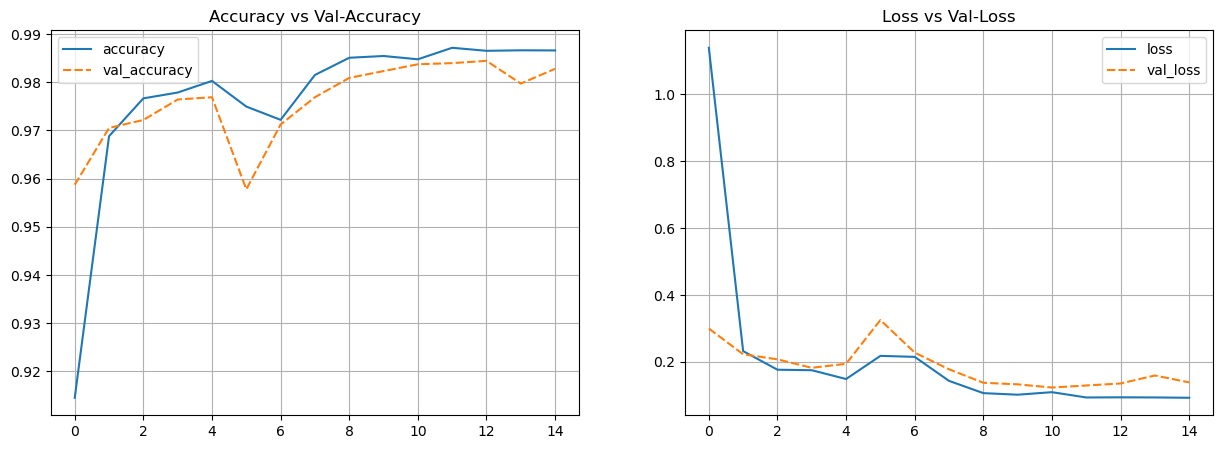

In [14]:
# Plot Training Results 
model_lstm_1_hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [19]:
# do prediciton with data test
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=-1)

# do prediciton with data train
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=-1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [42]:
def accuracy_score(words,y_true, y_pred):
    
    """
    Function to calculate accuracy
    -> param y_true: list of true values
    -> param y_pred: list of predicted values
    -> return: accuracy score
    
    """
    
    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = 0
    total_prediction = 0
    list_wrong_predict = []
    
    for yt_list, yp_list,word_index in zip(y_true, y_pred,words):
        for index in range(len(yt_list)):
            if yt_list[index] == yp_list[index]:
                correct_predictions += 1
            else:
                if word_index[index] == 0 or word_index[index] > len(word2idx):
                    word_desc = "Unknown"
                else:
                    word_desc = list(word2idx.keys())[list(word2idx.values()).index(word_index[index])]
                
                if yp_list[index] == 0 or yp_list[index] > len(tag2idx):
                    pred_desc = "O"
                else:
                    pred_desc = list(tag2idx.keys())[list(tag2idx.values()).index(yp_list[index])]

                if yt_list[index] == 0 or yt_list[index] > len(tag2idx):
                    actual_desc = "O"
                else:
                    actual_desc = list(tag2idx.keys())[list(tag2idx.values()).index(yt_list[index])]
                list_wrong_predict.append({
                    'word':word_desc,
                    'prediction':pred_desc,
                    'actual': actual_desc
                })
            total_prediction +=1
    
    
    #returns accuracy
    return correct_predictions / total_prediction,list_wrong_predict

In [43]:
accuracy_score_test,list_wrong_predict_test = accuracy_score(X_test,y_test,y_pred_test)
accuracy_score_train,list_wrong_predict_train = accuracy_score(X_train,y_train,y_pred_train)
print(f"Accuracy score in data train is = {accuracy_score_train}")
print(f"Accuracy score in data test is = {accuracy_score_test}")

Accuracy score in data train is = 0.987795089707271
Accuracy score in data test is = 0.985188679245283


In [44]:
list_wrong_predict_test

[{'word': 'merek', 'prediction': 'B-Device', 'actual': 'B-Merek'},
 {'word': 'kanan', 'prediction': 'O', 'actual': 'E-GamePerformance'},
 {'word': 'god', 'prediction': 'I-Game', 'actual': 'B-Game'},
 {'word': 'war', 'prediction': 'I-Game', 'actual': 'E-Game'},
 {'word': 'valo', 'prediction': 'B-Performance', 'actual': 'B-Game'},
 {'word': 'roleplay', 'prediction': 'O', 'actual': 'E-Game'},
 {'word': 'samsung', 'prediction': 'O', 'actual': 'B-Merek'},
 {'word': 'tambah', 'prediction': 'B-JenisMonitor', 'actual': 'B-Request'},
 {'word': 'total', 'prediction': 'O', 'actual': 'B-Harga'},
 {'word': 'edit', 'prediction': 'B-Game', 'actual': 'B-Kegiatan'},
 {'word': 'toko', 'prediction': 'O', 'actual': 'B-Toko'},
 {'word': 'world', 'prediction': 'O', 'actual': 'E-Game'},
 {'word': 'amd', 'prediction': 'B-Spek', 'actual': 'B-Merek'},
 {'word': 'suplai', 'prediction': 'O', 'actual': 'E-Spek'},
 {'word': 'gta', 'prediction': 'B-GamePerformance', 'actual': 'B-Game'},
 {'word': 'valorant', 'predic

## ***5. Model Save***

In [18]:
# Save best model
with open('./deployment_streamlit/model_NER.pkl', 'wb') as file1:
  pickle.dump(model, file1)

with open('model_NER.pkl', 'wb') as file2:
  pickle.dump(model, file2)